In [7]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
df_features = pd.read_csv("Features/df_all_features.csv")
df_targets = pd.read_csv("Features/df_all_targets.csv")

In [11]:
X = df_features
y = df_targets.values.ravel()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=53
)

In [13]:
from sklearn.ensemble import RandomForestClassifier

########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True', # more on this below
    random_state=69  
) 

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 93.19%


In [14]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      2000
           1       0.93      1.00      0.96      8812

    accuracy                           0.93     10812
   macro avg       0.95      0.82      0.87     10812
weighted avg       0.94      0.93      0.93     10812



In [36]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [58]:
X_balanced = df_features
y_balanced = df_targets.values.ravel()

In [59]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.3, 
    random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_balanced, 
    y_test_balanced, 
    test_size=0.33, 
    random_state=42
)

In [60]:
X_test.shape

(10866, 29)

In [61]:
X_train_balanced.shape, X_val.shape, X_balanced.shape

((37839, 29), (5352, 29), (54057, 29))

In [62]:
from numpy import mean
model_balanced = BalancedRandomForestClassifier(n_estimators=200)
model_balanced.fit(X_train_balanced, y_train_balanced)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model_balanced, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print(f'Random Forest Model\'s accuracy on training set is {100*model_balanced.score(X_train_balanced, y_train_balanced):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model_balanced.score(X_test_balanced, y_test_balanced):.2f}%')
print('Mean ROC AUC: %.3f' % mean(scores))

Random Forest Model's accuracy on training set is 96.75%
Random Forest Model's accuracy on test set is 89.95%
Mean ROC AUC: 0.929


In [63]:
from sklearn.metrics import classification_report
y_pred_balanced = model_balanced.predict(X_test)
print(classification_report(y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      2011
           1       0.97      0.91      0.94      8855

    accuracy                           0.90     10866
   macro avg       0.82      0.88      0.85     10866
weighted avg       0.91      0.90      0.90     10866



In [65]:
from sklearn.metrics import classification_report
y_pred_val = model_balanced.predict(X_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.69      0.86      0.77       997
           1       0.97      0.91      0.94      4355

    accuracy                           0.90      5352
   macro avg       0.83      0.89      0.85      5352
weighted avg       0.91      0.90      0.91      5352



In [82]:
# Save Model Using joblib
import joblib

In [83]:
# save the model to disk
filename = 'final_model.sav'
joblib.dump(model_balanced, filename, compress=3)

['final_model.sav']

In [84]:
# some time later...
 
# load the model from disk
loaded_model = joblib.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result_val = loaded_model.score(X_val, y_val)
y_pred_balanced = loaded_model.predict(X_test)
y_pred_val = loaded_model.predict(X_val)
print( classification_report(y_val, y_pred_val))
print("validation set: ", result_val)
print(classification_report(y_test, y_pred_balanced))
print("test set: ", result)

              precision    recall  f1-score   support

           0       0.69      0.86      0.77       997
           1       0.97      0.91      0.94      4355

    accuracy                           0.90      5352
   macro avg       0.83      0.89      0.85      5352
weighted avg       0.91      0.90      0.91      5352

validation set:  0.9019058295964125
              precision    recall  f1-score   support

           0       0.68      0.86      0.76      2011
           1       0.97      0.91      0.94      8855

    accuracy                           0.90     10866
   macro avg       0.82      0.88      0.85     10866
weighted avg       0.91      0.90      0.90     10866

test set:  0.898306644579422


In [66]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_balanced).ravel()
specificity = tn / (tn+fp)
tn, fp, fn, tp, specificity

(1720, 291, 814, 8041, 0.8552958727001492)

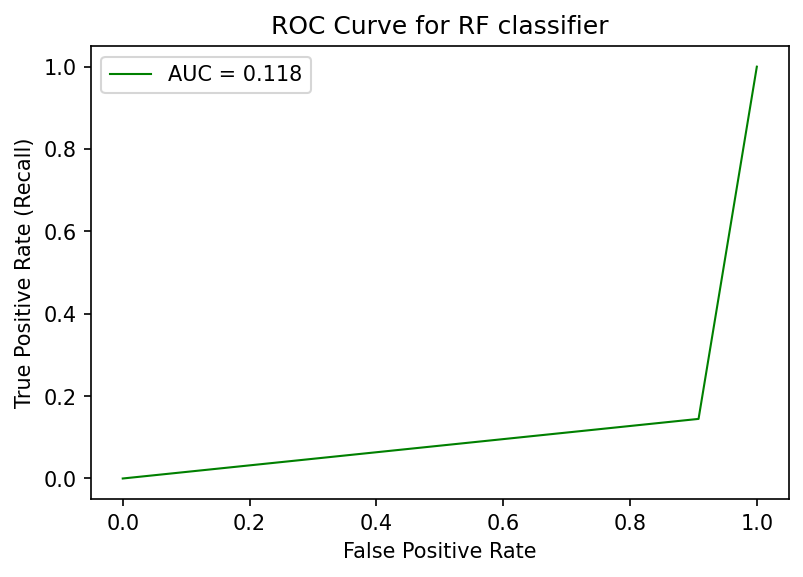

In [67]:
from sklearn.metrics import roc_curve, auc
# get false and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_balanced, pos_label=0)
# get area under the curve
roc_auc = auc(fpr, tpr)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

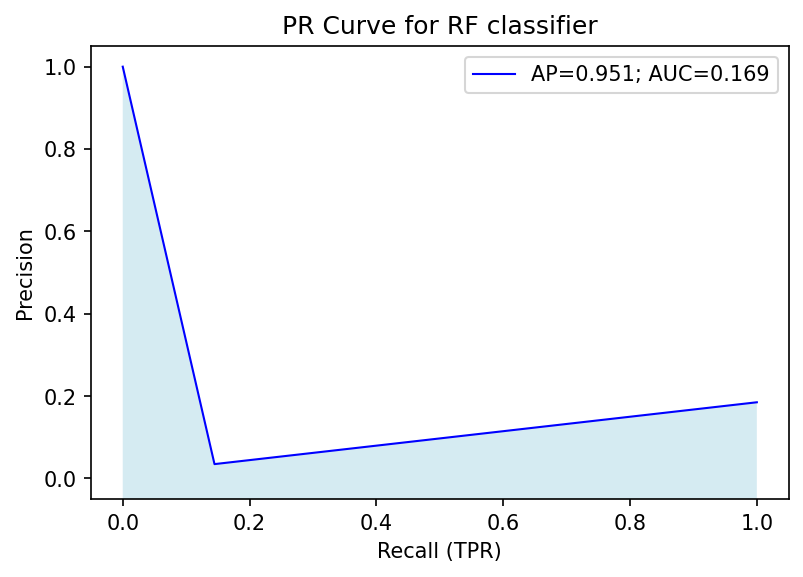

In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
# get precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_balanced, pos_label=0)
# average precision score
avg_precision = average_precision_score(y_test, y_pred_balanced)
# precision auc
pr_auc = auc(recall, precision)
# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)
plt.title('PR Curve for RF classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()